In [1]:
from miditoolkit.midi.parser import MidiFile
import numpy as np
import matplotlib.pyplot as plt

from deepnote import MusicRepr, Constants, Metric, Note, utils

## constants

In [2]:
const = Constants(
    unit=4,
    min_tempo=40,
    max_tempo=200,
    num_tempo_bins=20, 
    num_velocity_bins=20
)
const

Constants(unit=4, tick_resol=120, min_tempo=40, max_tempo=200, num_tempo_bins=20, num_velocity_bins=20)

## midi representation

In [3]:
# seq = MusicRepr.from_file(
#     '../test-1.mid', 
#     unit=4,
#     min_tempo=30,
#     max_tempo=300,
#     num_tempo_bins=30, 
#     num_velocity_bins=30
# )
seq = MusicRepr.from_file('assets/test.mid', const=const)
seq

MusicRepr(
 num_events=4307,
 const=Constants(unit=4, tick_resol=120, min_tempo=40, max_tempo=200, num_tempo_bins=20, num_velocity_bins=20)
)

In [4]:
seq.const

Constants(unit=4, tick_resol=120, min_tempo=40, max_tempo=200, num_tempo_bins=20, num_velocity_bins=20)

In [5]:
seq[:10]

[Bar(position=0, tempo=124),
 Beat(position=9, tempo=98),
 Bar(position=0),
 Beat(position=4),
 Note(inst_family=piano, pitch=64, duration=1, velocity=107),
 Beat(position=5),
 Note(inst_family=piano, pitch=65, duration=1, velocity=87),
 Beat(position=7),
 Note(inst_family=piano, pitch=67, duration=3, velocity=87),
 Beat(position=11)]

### splitting bars

In [6]:
seq.get_bar_count()

76

In [11]:
bars = seq.get_bars()
len(bars)

76

## concatenating bars

In [8]:
seq2 = MusicRepr.concatenate(bars[:2])
seq2.get_bar_count()

2

## Slicing

### bar index

In [9]:
seq2 = seq.slice_by_bar(1,2)
print(seq2.events == bars[1].events, seq2 == bars[1])

True True


### beat index

In [10]:
seq2 = seq.slice_by_beat(12, 16)
print(seq2.events == bars[3].events, seq2 == bars[3])

True True


### event index

In [11]:
seq2 = seq.slice_by_index(0,10)
seq2[:]

[Bar(position=0, tempo=123),
 Beat(position=9, tempo=104),
 Bar(position=0),
 Beat(position=4),
 Note(inst_family=piano, pitch=64, duration=1, velocity=105),
 Beat(position=5),
 Note(inst_family=piano, pitch=65, duration=1, velocity=87),
 Beat(position=7),
 Note(inst_family=piano, pitch=67, duration=3, velocity=87),
 Beat(position=11)]

## separating different instrument tracks

In [20]:
tracks = seq.separate_tracks()
list(tracks.keys()), seq.get_instruments()

(['drums', 'piano', 'bass', 'ensemble', 'guitar'],
 ['drums', 'piano', 'bass', 'ensemble', 'guitar'])

In [21]:
for inst in tracks:
    print(tracks[inst].get_bar_count())

76
76
76
76
76


In [22]:
tracks['bass'][:10]

[Bar(position=0, tempo=124),
 Beat(position=9, tempo=98),
 Bar(position=0),
 Bar(position=0, chord=G_M7),
 Note(inst_family=bass, pitch=43, duration=8, velocity=73),
 Beat(position=8, chord=B_m),
 Note(inst_family=bass, pitch=50, duration=8, velocity=73),
 Bar(position=0, chord=G_M7),
 Note(inst_family=bass, pitch=43, duration=8, velocity=80),
 Beat(position=8, chord=G_7)]

## exporting

### pianoroll

(128, 1216)


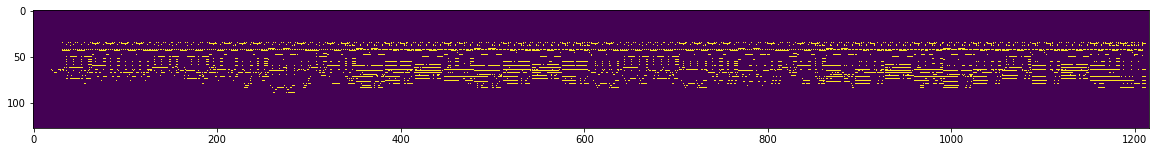

In [4]:
pianoroll = seq.to_pianoroll(separate_tracks=False, binarize=True) 
print(pianoroll.shape)
plt.figure(figsize=(20,10))
plt.imshow(pianoroll)
plt.show()

### midi

In [15]:
midi = seq.to_midi('assets/rec_test.mid')
midi

ticks per beat: 120
max tick: 36390
tempo changes: 2
time sig: 1
key sig: 0
markers: 70
lyrics: False
instruments: 5

### remi

In [4]:
remi = seq.to_remi(ret='token')
remi[:10]

['Bar',
 'BeatTempo_124',
 'BeatPosition_9',
 'BeatTempo_98',
 'Bar',
 'BeatPosition_4',
 'NoteInstFamily_piano',
 'NotePitch_64',
 'NoteDuration_1',
 'NoteVelocity_107']

In [10]:
seq.to_remi(ret='event')[:10]

[Event(type=Bar),
 Event(type=BeatTempo, value=124),
 Event(type=BeatPosition, value=9),
 Event(type=BeatTempo, value=98),
 Event(type=Bar),
 Event(type=BeatPosition, value=4),
 Event(type=NoteInstFamily, value=piano),
 Event(type=NotePitch, value=64),
 Event(type=NoteDuration, value=1),
 Event(type=NoteVelocity, value=107)]

In [8]:
seq.to_remi(ret='index', add_eos=True)[:10]

[0, 28, 11, 25, 0, 6, 170, 251, 315, 347]

### compound word

In [14]:
cp = seq.to_cp(add_eos=True)
cp.shape, len(seq)

((4308, 8), 4307)

In [12]:
bars[0].to_cp()

array([[ 0,  0, 11,  0,  0,  0,  0,  0],
       [ 0,  9,  8,  0,  0,  0,  0,  0]])

## Importing

### from pianoroll

In [6]:
pianorolls = seq.to_pianoroll(separate_tracks=True)
tracks = dict([(inst, 
                MusicRepr.from_single_pianoroll(pianorolls[inst], inst=inst, const=const)) 
               for inst in pianorolls])

seq_t = MusicRepr.merge_tracks(tracks)

In [9]:
seq_t.get_bar_count() == seq.get_bar_count()

True

### from cp

In [15]:
seq_t = MusicRepr.from_cp(cp, const=seq.const)
seq_t.events == seq.events, seq == seq_t

(True, True)

### from remi

In [6]:
seq_t = MusicRepr.from_string(' '.join(remi), const=seq.const)
seq_t.events == seq.events, seq == seq_t

IndexError: list index out of range

## merging tracks

In [23]:
seq_t = MusicRepr.merge_tracks(tracks)
seq == seq_t

True